In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
!pip install --upgrade xlrd #colab bug verson xlrd
!pip install geopandas
!pip install pandas fiona shapely pyproj rtree
!pip install contextily
!pip install pygeos
!pip install topojson
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
#!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
#!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a

In [2]:
eff = pd.read_csv("effectifs.csv", sep = ";", encoding = 'utf-8', engine = 'python')

In [3]:
pollution_group_dep = pd.read_csv("pollution_group_dep.csv", sep = ",", encoding = 'utf-8', engine = 'python')

In [7]:
pop = pd.read_csv('base_pop_dep.csv', sep = ",", encoding = 'utf-8', engine = 'python')

In [8]:
pop = pop.drop(['Unnamed: 0'], axis=1)

In [32]:
pop

,numero_dep,dep,total_habitants
0,01,Ain,671937
1,02,Aisne,522791
2,03,Allier,332443
3,04,Alpes-de-Haute-Provence,166654
4,05,Hautes-Alpes,139942
...,...,...,...
97,971,Guadeloupe,375845
98,972,Martinique,347686
99,973,Guyane,301099
100,974,La Réunion,873102


In [28]:
pollution_group_dep = pd.read_csv('pollution_group_dep.csv', sep = ",", encoding = 'utf-8', engine = 'python')

In [6]:
eff

,annee,patho_niv1,patho_niv2,patho_niv3,top,cla_age_5,sexe,region,dept,ntop,npop,prev,niveau_prioritaire,libelle_classe_age,libelle_sexe,tri
0,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,1.0,971,290.0,4210.0,6.912,"2,3",de 80 à 84 ans,hommes,51.0
1,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,3.0,973,40.0,650.0,5.864,"2,3",de 80 à 84 ans,hommes,51.0
2,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,4.0,999,410.0,5630.0,7.340,"2,3",de 80 à 84 ans,hommes,51.0
3,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,6.0,999,20.0,350.0,4.913,"2,3",de 80 à 84 ans,hommes,51.0
4,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,11.0,75,2960.0,20820.0,14.221,"2,3",de 80 à 84 ans,hommes,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541235,2019,Insuffisance rénale chronique terminale,Dialyse chronique,Dialyse chronique,top_RDialyse_ind,35-39,1.0,2.0,999,10.0,7090.0,0.169,"2,3",de 35 à 39 ans,hommes,23.0
2541236,2021,Maladies neurologiques ou dégénératives,Sclérose en plaques,Sclérose en plaques,top_NSePlaq_ind,45-49,9.0,27.0,58,40.0,11420.0,0.350,"2,3",de 45 à 49 ans,tous sexes,42.0
2541237,2019,Insuffisance rénale chronique terminale,Dialyse chronique,Dialyse chronique,top_RDialyse_ind,35-39,1.0,3.0,973,NaN,5010.0,NaN,"2,3",de 35 à 39 ans,hommes,23.0
2541238,2021,Maladies neurologiques ou dégénératives,Sclérose en plaques,Sclérose en plaques,top_NSePlaq_ind,45-49,9.0,27.0,90,40.0,8720.0,0.470,"2,3",de 45 à 49 ans,tous sexes,42.0


In [9]:
# Fusion des tables effectifs, pop et pollution_group_dep

merged_df = pd.merge(eff, pollution_group_dep, left_on=['dept'], right_on=['DEP'], 
                    how='inner')
pop_eff_pol = pd.merge(merged_df, pop, left_on=['DEP'], right_on=['numero_dep'], 
                    how='inner')

# Supprimer les colonnes redondantes
pop_eff_pol = pop_eff_pol.drop(['numero_dep', 'dept'], axis=1)

#Pour ne pas confondre les variables DEP (int) et dep (str)
pop_eff_pol = pop_eff_pol.rename(columns={'dep': 'nom_dep'})

In [10]:
pop_eff_pol

,annee,patho_niv1,patho_niv2,patho_niv3,top,cla_age_5,sexe,region,ntop,npop,...,Autres transports international,CO2 biomasse hors-total,Déchets,Energie,Industrie hors-énergie,Résidentiel,Routier,Tertiaire,nom_dep,total_habitants
0,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,11.0,2960.0,20820.0,...,183.766008,1.186577e+06,27358.781206,147965.117571,434314.469384,1.934580e+06,1.625583e+06,1.331630e+06,Paris,2102650
1,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,9.0,11.0,7990.0,50520.0,...,183.766008,1.186577e+06,27358.781206,147965.117571,434314.469384,1.934580e+06,1.625583e+06,1.331630e+06,Paris,2102650
2,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,90-94,2.0,11.0,1450.0,14960.0,...,183.766008,1.186577e+06,27358.781206,147965.117571,434314.469384,1.934580e+06,1.625583e+06,1.331630e+06,Paris,2102650
3,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,95et+,2.0,11.0,370.0,7540.0,...,183.766008,1.186577e+06,27358.781206,147965.117571,434314.469384,1.934580e+06,1.625583e+06,1.331630e+06,Paris,2102650
4,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,tsage,2.0,11.0,41370.0,1119660.0,...,183.766008,1.186577e+06,27358.781206,147965.117571,434314.469384,1.934580e+06,1.625583e+06,1.331630e+06,Paris,2102650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032869,2021,Maladies neurologiques ou dégénératives,Sclérose en plaques,Sclérose en plaques,top_NSePlaq_ind,35-39,2.0,53.0,80.0,16720.0,...,293.809962,5.929728e+05,135543.139833,65762.797711,283874.799468,4.761495e+05,1.273879e+06,3.598942e+05,Côtes-d'Armor,607834
2032870,2019,Insuffisance rénale chronique terminale,Dialyse chronique,Dialyse chronique,top_RDialyse_ind,25-29,1.0,53.0,NaN,12770.0,...,293.809962,5.929728e+05,135543.139833,65762.797711,283874.799468,4.761495e+05,1.273879e+06,3.598942e+05,Côtes-d'Armor,607834
2032871,2019,Insuffisance rénale chronique terminale,Dialyse chronique,Dialyse chronique,top_RDialyse_ind,25-29,2.0,53.0,NaN,13330.0,...,293.809962,5.929728e+05,135543.139833,65762.797711,283874.799468,4.761495e+05,1.273879e+06,3.598942e+05,Côtes-d'Armor,607834
2032872,2021,Maladies neurologiques ou dégénératives,Sclérose en plaques,Sclérose en plaques,top_NSePlaq_ind,45-49,2.0,53.0,100.0,19200.0,...,293.809962,5.929728e+05,135543.139833,65762.797711,283874.799468,4.761495e+05,1.273879e+06,3.598942e+05,Côtes-d'Armor,607834


In [ ]:
#Les données datent de 2015 à 2020, 
#on prend le classement par PIB par habitant par département et on garde 
#le dep avec le PIB par habitant le plus élevé (Paris (75), pib/habitant de 127 132€)
#celui où il est le plus faible (la Creuse (23), pib/habitant de 23 192€),
#et celui qui est le plus près de la moyenne nationale (Bas-Rhin (67)).
#Le PIB moyen par habitant en 2021 est de 37 431€ par an.
# source : wikipedia

In [11]:
pop_eff_pol['nom_dep'].unique()

array(['Paris', 'Val-de-Marne', "Val-d'Oise", 'Doubs', 'Nièvre', 'Eure',
       'Orne', 'Pas-de-Calais', 'Somme', 'Meurthe-et-Moselle', 'Bas-Rhin',
       'Mayenne', 'Gironde', 'Landes', 'Lot-et-Garonne', 'Vienne',
       'Hérault', 'Lot', 'Lozère', 'Hautes-Pyrénées', 'Tarn-et-Garonne',
       'Ariège', 'Ain', 'Puy-de-Dôme', 'Rhône', 'Haute-Savoie',
       'Haute-Corse', 'Essonne', 'Hauts-de-Seine', 'Eure-et-Loir',
       'Indre-et-Loire', 'Loir-et-Cher', 'Loiret', 'Yonne',
       'Territoire de Belfort', 'Calvados', 'Aube', 'Marne',
       'Haute-Marne', 'Moselle', 'Ardennes', 'Maine-et-Loire', 'Sarthe',
       'Vendée', 'Ille-et-Vilaine', 'Morbihan', 'Dordogne',
       'Pyrénées-Atlantiques', 'Aveyron', 'Pyrénées-Orientales', 'Allier',
       'Isère', 'Loire', 'Alpes-Maritimes', 'Vaucluse', 'Yvelines',
       'Cher', "Côte-d'Or", 'Aisne', 'Haut-Rhin', 'Charente-Maritime',
       'Creuse', 'Deux-Sèvres', 'Haute-Vienne', 'Gard', 'Haute-Garonne',
       'Gers', 'Cantal', 'Bouches-du-Rhô

In [20]:
for x in pop_eff_pol['nom_dep'].unique() :
 print (x, len(pop_eff_pol[(pop_eff_pol['nom_dep'] == x) & (pop_eff_pol['patho_niv1'] == 'Hospitalisations ponctuelles (avec ou sans pathologies, traitements ou maternité)')]))

Paris 252
Val-de-Marne 264
Val-d'Oise 264
Doubs 265
Nièvre 255
Eure 262
Orne 265
Pas-de-Calais 256
Somme 249
Meurthe-et-Moselle 262
Bas-Rhin 272
Mayenne 259
Gironde 262
Landes 267
Lot-et-Garonne 256
Vienne 236
Hérault 236
Lot 246
Lozère 254
Hautes-Pyrénées 255
Tarn-et-Garonne 270
Ariège 262
Ain 285
Puy-de-Dôme 265
Rhône 251
Haute-Savoie 250
Haute-Corse 253
Essonne 263
Hauts-de-Seine 245
Eure-et-Loir 259
Indre-et-Loire 256
Loir-et-Cher 254
Loiret 252
Yonne 255
Territoire de Belfort 266
Calvados 248
Aube 262
Marne 258
Haute-Marne 242
Moselle 265
Ardennes 265
Maine-et-Loire 272
Sarthe 247
Vendée 276
Ille-et-Vilaine 262
Morbihan 264
Dordogne 249
Pyrénées-Atlantiques 251
Aveyron 262
Pyrénées-Orientales 255
Allier 263
Isère 263
Loire 274
Alpes-Maritimes 268
Vaucluse 249
Yvelines 250
Cher 272
Côte-d'Or 281
Aisne 249
Haut-Rhin 267
Charente-Maritime 257
Creuse 262
Deux-Sèvres 255
Haute-Vienne 275
Gard 255
Haute-Garonne 231
Gers 249
Cantal 259
Bouches-du-Rhône 249
Var 262
Seine-Saint-Denis 270
I

In [16]:
len(pop_eff_pol[(pop_eff_pol['nom_dep'] == 'Creuse') & (pop_eff_pol['patho_niv1'] == 'Hospitalisations ponctuelles (avec ou sans pathologies, traitements ou maternité)')])

262

In [17]:
len(pop_eff_pol[(pop_eff_pol['nom_dep'] == 'Paris') & (pop_eff_pol['patho_niv1'] == 'Hospitalisations ponctuelles (avec ou sans pathologies, traitements ou maternité)')])

252

In [ ]:
# Filtrer les données pour le département 75 (Paris) et la variable patho_niv1
paris_data = pop_eff_pol[pop_eff_pol['nom_dep'] == 'Paris']
hospitalized_data = paris_data[paris_data['patho_niv1'] == 'Hospitalisations ponctuelles (avec ou sans pathologies, traitements ou maternité)']

# Calculer la proportion de personnes hospitalisées
proportion_hospitalized = len(hospitalized_data) / paris_data['total_habitants'].sum()

# Créer un histogramme
labels = ['Hospitalisés', 'Non hospitalisés']
sizes = [proportion_hospitalized, 1 - proportion_hospitalized]

fig, ax = plt.subplots()
ax.bar(labels, sizes, color=['blue', 'gray'])
ax.set_ylabel('Proportion')
ax.set_title('Proportion de personnes hospitalisées dans le département 75 (Paris)')

plt.show()

In [ ]:
# On en voit rien vu que la proportion de personnes 
#hospitalisées sur la population parisienne totale est néglgeable
#idée : prendre en compte la variable niveau_prioritaire pour comparer

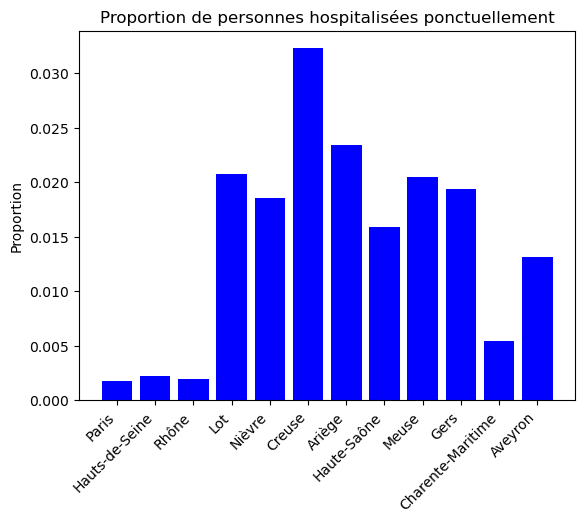

In [79]:
# Liste des départements
departements = ['Paris', 'Hauts-de-Seine', 'Rhône', 'Lot', 'Nièvre', 'Creuse', 'Ariège', 'Haute-Saône', 'Meuse', 'Gers', 'Charente-Maritime', 'Aveyron']

#Patho_niv1 sélectionné
x = 'Cancers'

# Création de dictionnaires pour la suite
hospitalized_data_by_dep = {}
data_by_dep = {}
population_by_dep = {}
proportion_hospitalized_by_dep = {}

# Boucle pour filtrer les données pour chaque département
for dep in departements:
    data_by_dep[dep] = pop_eff_pol[pop_eff_pol['nom_dep'] == dep]

# Boucle pour filtrer les données pour chaque département
for dep in departements:
    dep_data = pop_eff_pol[pop_eff_pol['nom_dep'] == dep]
    hospitalized_data = dep_data[dep_data['patho_niv1'] == x]
    hospitalized_data_by_dep[dep] = hospitalized_data

# Boucle pour obtenir le nombre d'habitants pour chaque département
for dep in departements:
    population_by_dep[dep] = pop.loc[pop['dep'] == dep, 'total_habitants'].iloc[0]

# Boucle pour calculer les proportions pour chaque département
for dep in departements:
    # Filtrer les données hospitalisées pour le département actuel
    hospitalized_data = data_by_dep[dep][data_by_dep[dep]['patho_niv1'] == x]
    # Calculer la proportion de personnes hospitalisées
    proportion_hospitalized = len(hospitalized_data) / population_by_dep[dep]
    
    # Stocker la proportion dans le dictionnaire
    proportion_hospitalized_by_dep[dep] = proportion_hospitalized
    
# Créer une liste pour stocker les tailles des barres
sizes = []

# Boucle pour récupérer les proportions spécifiques à chaque département
for dep in departements:
    sizes.append(proportion_hospitalized_by_dep[dep])

# Créer un diagramme en barres
fig, ax = plt.subplots()
ax.bar(departements, sizes, color=['blue'])
ax.set_ylabel('Proportion')
ax.set_title('Proportion de personnes hospitalisées ponctuellement')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(departements, rotation=45, ha='right')

plt.show()

In [ ]:
type(pop_eff_pol['niveau_prioritaire'])

In [ ]:
pop_eff_pol['niveau_prioritaire'].unique()

In [ ]:
pop_eff_pol['niveau_prioritaire'].replace('1,2,3', np.nan, inplace=True)

In [ ]:
# Filtrer les données pour le département 75 (Paris)
paris_data = pop_eff_pol[(pop_eff_pol['nom_dep'] == 'Paris')]

# Trier le DataFrame en fonction de la variable 'niveau_prioritaire'
paris_data = paris_data.sort_values(by='niveau_prioritaire')

# Calculer la proportion de chaque valeur de niveau_prioritaire
proportion_niveau_prioritaire = paris_data['niveau_prioritaire'].value_counts(normalize=True)

# Créer un graphique à barres
ax = proportion_niveau_prioritaire.plot(kind='bar', color=['green', 'orange', 'red', 'darkcyan'])
plt.ylabel('Proportion')
plt.xlabel('Niveau de priorité')
plt.title('Proportion de chaque niveau prioritaire à Paris')

# Fonction pour ajouter les pourcentages au-dessus des barres
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height, f'{height:.1%}',
                ha='center', va='bottom')

# Appeler la fonction autolabel avec les barres actuelles
autolabel(ax.patches)

# Changer l'orientation des étiquettes de l'axe x
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()

In [ ]:
# Filtrer les données pour le département 23 (Creuse)
paris_data = pop_eff_pol[(pop_eff_pol['nom_dep'] == 'Creuse')]

# Trier le DataFrame en fonction de la variable 'niveau_prioritaire'
paris_data = paris_data.sort_values(by='niveau_prioritaire')

# Calculer la proportion de chaque valeur de niveau_prioritaire
proportion_niveau_prioritaire = paris_data['niveau_prioritaire'].value_counts(normalize=True)

# Créer un graphique à barres
ax = proportion_niveau_prioritaire.plot(kind='bar', color=['green', 'orange', 'red', 'darkcyan'])
plt.ylabel('Proportion')
plt.xlabel('Niveau de priorité')
plt.title('Proportion de chaque niveau prioritaire dans la Creuse')

# Appeler la fonction autolabel avec les barres actuelles
autolabel(ax.patches)

# Changer l'orientation des étiquettes de l'axe x
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()

In [ ]:
# Filtrer les données pour le département 67 (Bas-Rhin)
paris_data = pop_eff_pol[(pop_eff_pol['nom_dep'] == 'Bas-Rhin')]

# Trier le DataFrame en fonction de la variable 'niveau_prioritaire'
paris_data = paris_data.sort_values(by='niveau_prioritaire')

# Calculer la proportion de chaque valeur de niveau_prioritaire
proportion_niveau_prioritaire = paris_data['niveau_prioritaire'].value_counts(normalize=True)

# Créer un graphique à barres
ax = proportion_niveau_prioritaire.plot(kind='bar', color=['mediumseagreen', 'navajowhite', 'lightcoral', 'darkcyan'])
plt.ylabel('Proportion')
plt.xlabel('Niveau de priorité')
plt.title('Proportion de chaque niveau prioritaire dans la Creuse')

# Appeler la fonction autolabel avec les barres actuelles
autolabel(ax.patches)

# Changer l'orientation des étiquettes de l'axe x
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()

In [ ]:
# Trier le DataFrame en fonction de la variable 'niveau_prioritaire'
paris_data = pop_eff_pol.sort_values(by='niveau_prioritaire')

# Calculer la proportion de chaque valeur de niveau_prioritaire
proportion_niveau_prioritaire = paris_data['niveau_prioritaire'].value_counts(normalize=True)

# Créer un graphique à barres
ax = proportion_niveau_prioritaire.plot(kind='bar', color=['green', 'orange', 'red', 'darkcyan'])
plt.ylabel('Proportion')
plt.xlabel('Niveau de priorité')
plt.title('Proportion de chaque niveau prioritaire dans la Creuse')

# Appeler la fonction autolabel avec les barres actuelles
autolabel(ax.patches)

# Changer l'orientation des étiquettes de l'axe x
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()